## Neural Style Transfer

Today, we will try neural style transfer, relative to content images and style images.

- The idea is based on [Image Style Transfer Using Convolutional Neural Networks (Gatys et al.)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).
- The code is based on [medium post](https://medium.com/gradientcrescent/neural-art-style-transfer-with-keras-theory-and-implementation-91b7fb08ee81) and [tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/style_transfer).

### Prepare content, style image

- The content image is a photo of LOTTE Tower in South Korea, which is taken by me.
- The style image is an artwork called "The Scream" by Edvard Munch.

![](./content.jpg)
![](./style.jpg)

In [1]:
content_img_path = './content.jpg'
style_img_path = './style.jpg'

# I already resized images as 600 x 400
img_width = 600
img_height = 400

In [2]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img


def preprocess_img(path):
    img = load_img(path, target_size=(img_height, img_width))
    img = img_to_array(img)
    
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    
    return img

def depreprocess_img(img):
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    
    img = img[:, :, ::-1] # BGR, RGB
    
    img = np.clip(img, 0, 255).astype('uint8')
    return img

### Create Extractor model

In [3]:
content_layers = ['block5_conv2'] 

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1', 
    'block4_conv1', 
    'block5_conv1'
]

def build_extractor(layer_names):    
    model = vgg19.VGG19(
        weights='imagenet',
        include_top=False
    )
    model.trainable = False

    outputs = [model.get_layer(name).output for name in layer_names]
    model = tf.keras.Model(inputs=model.input, outputs=outputs)
    return model

content_extractor = build_extractor(content_layers)
style_extractor = build_extractor(style_layers)

content_img = preprocess_img(content_img_path)
style_img = preprocess_img(style_img_path)

content_features = content_extractor(content_img)
style_features = style_extractor(style_img)

### Define loss functions

In [4]:
from tensorflow.keras import backend as K

lambda_content = 0.025
lambda_style = 1.

comb_img = tf.Variable(content_img)


def calc_content_loss(content, comb):
    return K.sum(K.square(comb - content))


def gram_matrix(_fmap):
    def batch_flatten(x):
        """re-defined due to tf2 issue"""
        shape = x.get_shape().as_list()
        last_dim = np.prod(shape[1:])
        return tf.reshape(x, [-1, last_dim])
    
    fmap = batch_flatten(K.permute_dimensions(_fmap, (3, 0, 1, 2)))
    gram = K.dot(fmap, K.transpose(fmap))
    return gram


def calc_style_loss(style, comb):
    gram_s = gram_matrix(style)
    gram_g = gram_matrix(comb)
    
    channels = 3
    size = img_height * img_width
    
    return K.sum(K.square(gram_g - gram_s) / (4. * (channels ** 2) * (size ** 2)))


def style_content_loss(img):
    comb_content_features = content_extractor(img)
    comb_style_features = style_extractor(img)
    
    content_loss = tf.add_n([
        calc_content_loss(content_features[i], comb_content_features[i])
        for i in range(len(content_layers))
    ])
    style_loss = tf.add_n([
        calc_style_loss(style_features[i], comb_style_features[i])
        for i in range(len(style_layers))
    ])
    
    loss = lambda_content * content_loss + lambda_style * style_loss
    return loss

### Train!

In [5]:
opt = tf.optimizers.Adam(learning_rate=0.002, beta_1=0.99, epsilon=1e-1)

@tf.function()
def train_step(img):
    with tf.GradientTape() as tape:
        loss = style_content_loss(img)

    grad = tape.gradient(loss, img)
    opt.apply_gradients([(grad, img)])

In [6]:
import matplotlib.pyplot as plt

epochs = 20
steps_per_epoch = 1000

for i in range(epochs):
    print("current epoch: %d / %d" % (i, epochs))
    for j in range(steps_per_epoch):
        train_step(comb_img)

current epoch: 0 / 20
current epoch: 1 / 20
current epoch: 2 / 20
current epoch: 3 / 20
current epoch: 4 / 20
current epoch: 5 / 20
current epoch: 6 / 20
current epoch: 7 / 20
current epoch: 8 / 20
current epoch: 9 / 20
current epoch: 10 / 20
current epoch: 11 / 20
current epoch: 12 / 20
current epoch: 13 / 20
current epoch: 14 / 20
current epoch: 15 / 20
current epoch: 16 / 20
current epoch: 17 / 20
current epoch: 18 / 20
current epoch: 19 / 20


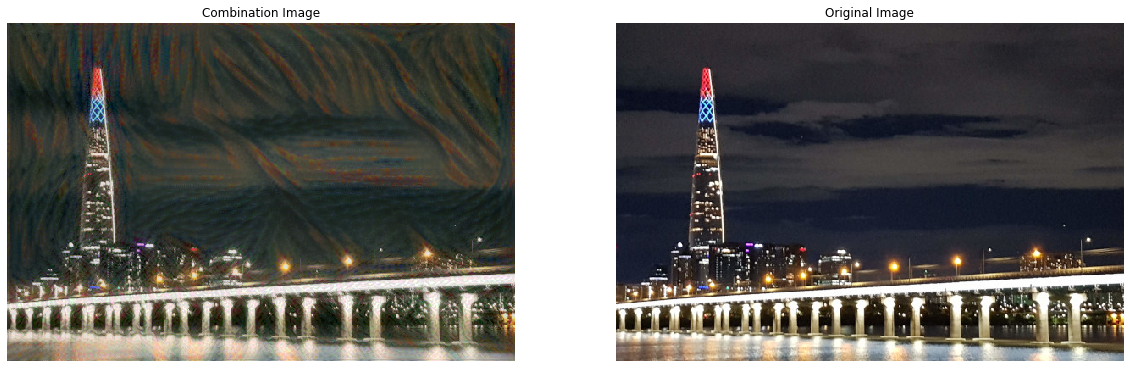

In [7]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title('Combination Image')
plt.axis('off')
plt.imshow(depreprocess_img(comb_img.numpy()[0, :, :, :]))

plt.subplot(1, 2, 2)
plt.title('Original Image')
plt.axis('off')
plt.imshow(depreprocess_img(content_img[0, :, :, :]))